# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages, which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission if necessary. 

> **Note**: Once you have completed all of the code implementations, you need to finalize your work by exporting the iPython Notebook as an HTML document. Before exporting the notebook to html, all of the code cells need to have been run so that reviewers can see the final implementation and output. You can then export the notebook by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission. 

In addition to implementing code, there is a writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-Traffic-Sign-Classifier-Project/blob/master/writeup_template.md) that can be used to guide the writing process. Completing the code template and writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/481/view) for this project.

The [rubric](https://review.udacity.com/#!/rubrics/481/view) contains "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. The stand out suggestions are optional. If you decide to pursue the "stand out suggestions", you can include the code in this Ipython notebook and also discuss the results in the writeup file.


>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

In [25]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import cv2

---
## Step 0: Load The Data

In [26]:
# Load pickled data
import pickle

# TODO: Fill this in based on where you saved the training and testing data

training_file = 'train.p'
validation_file ='valid.p'
testing_file = 'test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

In [27]:
print(X_train[0].dtype)

uint8


In [28]:
# Shuffle the training data
from sklearn.utils import shuffle

X_train, y_train = shuffle(X_train, y_train)

---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

Complete the basic data summary below. Use python, numpy and/or pandas methods to calculate the data summary rather than hard coding the results. For example, the [pandas shape method](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.shape.html) might be useful for calculating some of the summary results. 

### Provide a Basic Summary of the Data Set Using Python, Numpy and/or Pandas

In [29]:
### Replace each question mark with the appropriate value. 
### Use python, pandas or numpy methods rather than hard coding the results

# TODO: Number of training examples
n_train = X_train.shape[0]

# TODO: Number of validation examples
n_validation = X_valid.shape[0]

# TODO: Number of testing examples.
n_test = X_test.shape[0]

# TODO: What's the shape of an traffic sign image?
image_shape = X_train[0].shape

# TODO: How many unique classes/labels there are in the dataset.
n_classes = len(set(y_train))

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 34799
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


### Include an exploratory visualization of the dataset

Visualize the German Traffic Signs Dataset using the pickled file(s). This is open ended, suggestions include: plotting traffic sign images, plotting the count of each sign, etc. 

The [Matplotlib](http://matplotlib.org/) [examples](http://matplotlib.org/examples/index.html) and [gallery](http://matplotlib.org/gallery.html) pages are a great resource for doing visualizations in Python.

**NOTE:** It's recommended you start with something simple first. If you wish to do more, come back to it after you've completed the rest of the sections. It can be interesting to look at the distribution of classes in the training, validation and test set. Is the distribution the same? Are there more examples of some classes than others?

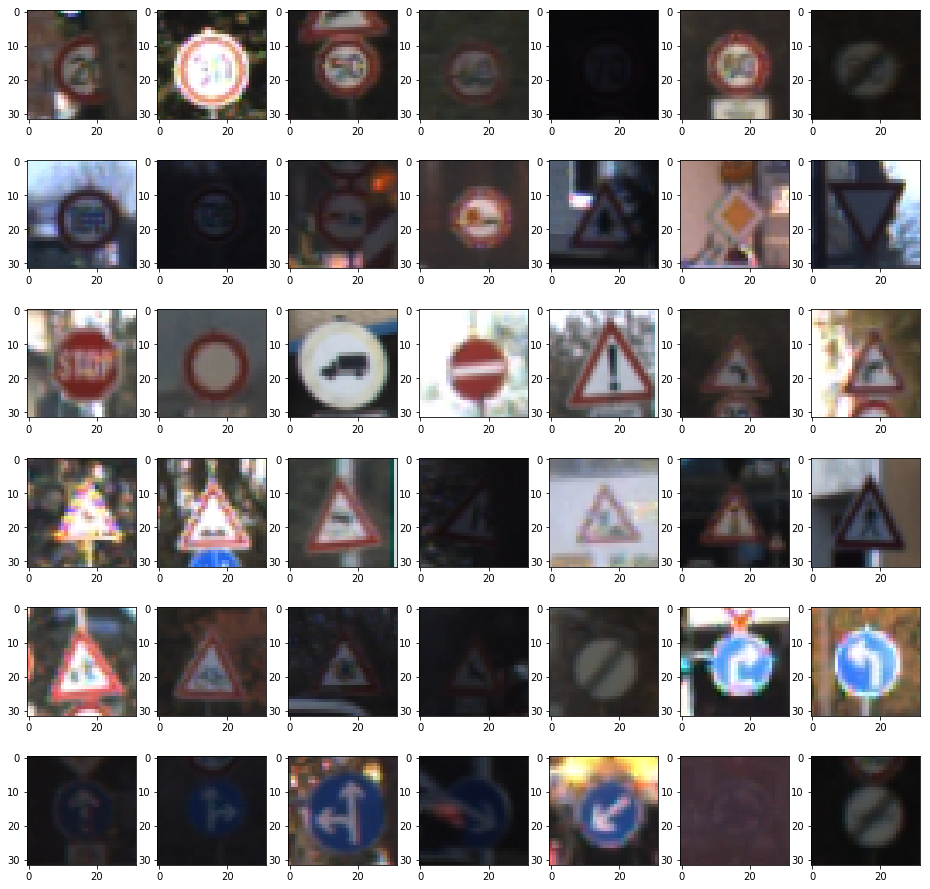

In [30]:
### Data exploration visualization code goes here.
### Feel free to use as many code cells as needed.
# Visualizations will be shown in the notebook.
%matplotlib inline
first_index_labels_valid = [np.where(y_valid == label)[0][0] for label in set(y_valid)]
label_images = [X_valid[idx] for idx in first_index_labels_valid]
plt.subplots(6, 7, figsize=(16, 16))
for idx, img, in enumerate(label_images[:-1]):
    plt.subplot(6, 7, idx+1)
    plt.imshow(img)
plt.show()

## Inspect the distributions of Labels

### Training Data

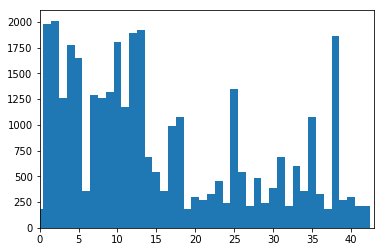

In [31]:
train_hist, bin_edges = np.histogram(y_train, bins = range(n_classes + 1))
plt.bar(bin_edges[:-1], train_hist, width=1)
plt.xlim(min(bin_edges), max(bin_edges))
plt.show()

### Validation data classes

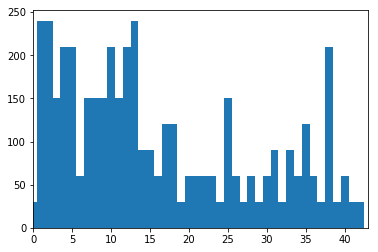

In [32]:
valid_hist, bin_edges = np.histogram(y_valid, bins = range(n_classes + 1))
plt.bar(bin_edges[:-1], valid_hist, width=1)
plt.xlim(min(bin_edges), max(bin_edges))
plt.show()

Clearly the data is unevenly distributed. This would cause the more frequently appearing classes to be learnt well as opposed to the ones low in number. There are 2 ways to solve this problem:
* Discard all the class samples appearing more in number to 'downsample' to the ```min(hist)``` - which seems silly, since we would be discarding a lot of useful samples just to make it evenly distributed
* The more robust but difficult one would be to generate fabricated data to boost the numbers of low numbered classes

*Additional data will be augmented after converting images to grayscale below*

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

The LeNet-5 implementation shown in the [classroom](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) at the end of the CNN lesson is a solid starting point. You'll have to change the number of classes and possibly the preprocessing, but aside from that it's plug and play! 

With the LeNet-5 solution from the lecture, you should expect a validation set accuracy of about 0.89. To meet specifications, the validation set accuracy will need to be at least 0.93. It is possible to get an even higher accuracy, but 0.93 is the minimum for a successful project submission. 

There are various aspects to consider when thinking about this problem:

- Neural network architecture (is the network over or underfitting?)
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

## Pre-process the Data Set (normalization, grayscale, etc.)

### 1. Grayscale the images

In [33]:
### Preprocess the data here. It is required to normalize the data. Other preprocessing steps could include 
### converting to grayscale, etc.
### Feel free to use as many code cells as needed.

def grayscale(images):
    return [cv2.cvtColor(img, cv2.COLOR_RGB2GRAY) for img in images]


X_train_gray = grayscale(X_train)
X_valid_gray = grayscale(X_valid)
X_test_gray = grayscale(X_test)
print(X_train_gray[0].shape)

(32, 32)


#### Data manipulation functions that will be used to generate augmentd data

In [34]:
import random


def random_rotate(img):
    '''Rotate :img: by anti-clockwise direction'''
    degrees = random.randint(1, 25)
    (h, w) = img.shape[:2]
    center = (w / 2, h / 2) 
    M = cv2.getRotationMatrix2D(center, degrees, 1.0)
    return cv2.warpAffine(img, M, (w, h))


def random_translate(img):
    rows,cols = img.shape[:2]
    shift_range = 5
    offset = random.randint(-shift_range, shift_range)
    M = np.float32([[1, 0, offset], [0, 1, offset]])
    return cv2.warpAffine(img,M,(cols,rows))


def random_brightness(img):
    shifted = img + 1.0
    max_value = max(shifted.flatten())
    max_ = 2.0/max_value
    min_ = max_ - 0.1
    coef = np.random.uniform(min_, max_)
    return shifted * coef - 1.0
    

#### Plotting some random images to compare the effects of data manipulation. Top row is original. Bottom is modified

In [35]:
n_random_imgs = 7

def plot_augmented_data(aug_func, n_imgs):
    original_imgs = [X_train_gray[random.randint(1, 10000)] for _ in range(n_random_imgs)]
    modified_imgs = [aug_func(img) for img in original_imgs]
    plt.subplots(2, n_imgs, figsize=(16, 5))
    plt.suptitle('%s applied' % (aug_func.__name__))
    for idx, img in enumerate(original_imgs):
        plt.subplot(2, n_imgs, idx + 1)
        plt.imshow(img, cmap='gray')
    for idx, img in enumerate(modified_imgs):
        plt.subplot(2, n_imgs, len(original_imgs) + idx + 1)
        plt.imshow(img, cmap='gray')
    
    plt.show()

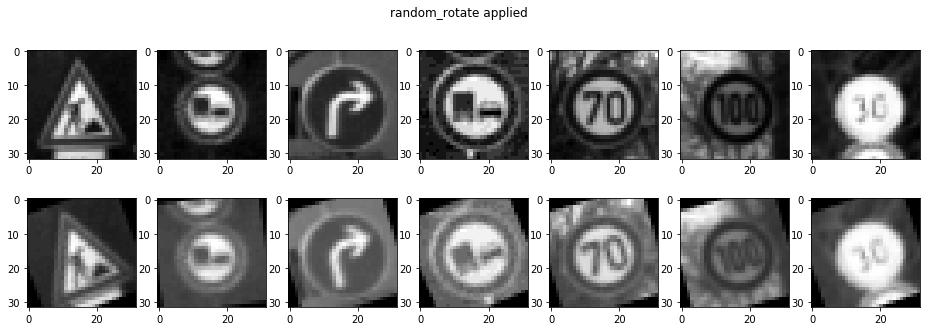

In [36]:
plot_augmented_data(random_rotate, n_random_imgs)

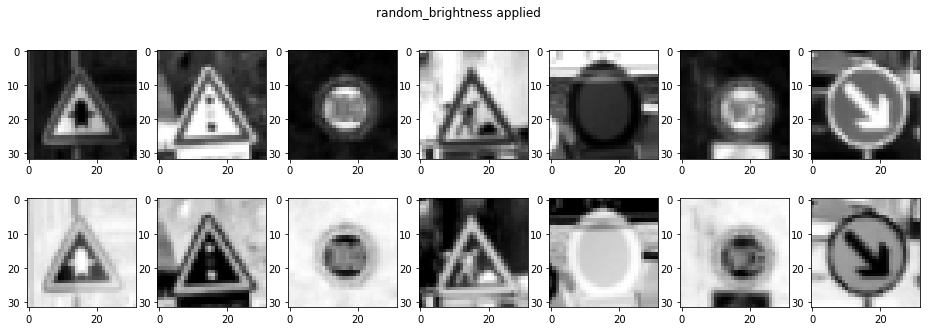

In [13]:
plot_augmented_data(random_brightness, n_random_imgs)

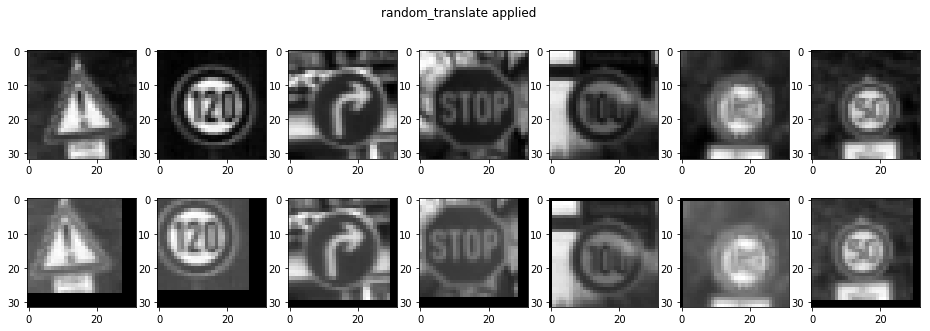

In [14]:
plot_augmented_data(random_translate, n_random_imgs)

### 2. Normalize the data to have zero mean

In [37]:
def normalize(images):
    images = [img.reshape(32, 32, 1) for img in images]
    lst = [(img - 128.0) / 128 for img in images]
    return np.asarray(lst).reshape(len(lst), 32, 32, 1)

In [38]:
X_train = normalize(X_train_gray)
X_valid = normalize(X_valid_gray)
X_test = normalize(X_test_gray)

### Data Augmentation
For each dataset, we want to boost the minority classes' count upto the mean of counts of all classes 

In [39]:
def augment_data(data, labels):
    hist, _ = np.histogram(labels, bins = range(n_classes + 1))
    boost_limit = int(np.mean(hist))
    minorities = [(idx, count) for idx, count in enumerate(hist) if count < boost_limit]
    print(minorities)
    for cls, count in minorities:
        print('%s with count % started' % (cls, count) + '~' * 10)
        rem = boost_limit - count
        for _ in range(rem):
            aug_func = random.choice([random_rotate, random_translate, random_brightness])
            cls_data = np.where(labels == cls)
            rand_img = data[random.choice(cls_data[0])]
            data = np.append(data, [aug_func(rand_img).reshape(32, 32, 1)], axis=0)
            labels = np.append(labels, [cls])
    return data, labels

In [16]:
X_valid, y_valid = augment_data(X_valid, y_valid)
X_train, y_train = augment_data(X_train, y_train)

[(0, 30), (6, 60), (14, 90), (15, 90), (16, 60), (19, 30), (20, 60), (21, 60), (22, 60), (23, 60), (24, 30), (26, 60), (27, 30), (28, 60), (29, 30), (30, 60), (31, 90), (32, 30), (33, 90), (34, 60), (36, 60), (37, 30), (39, 30), (40, 60), (41, 30), (42, 30)]
0 with count 30tarted~~~~~~~~~~
6 with count 60tarted~~~~~~~~~~
14 with count 90tarted~~~~~~~~~~
15 with count 90tarted~~~~~~~~~~
16 with count 60tarted~~~~~~~~~~
19 with count 30tarted~~~~~~~~~~
20 with count 60tarted~~~~~~~~~~
21 with count 60tarted~~~~~~~~~~
22 with count 60tarted~~~~~~~~~~
23 with count 60tarted~~~~~~~~~~
24 with count 30tarted~~~~~~~~~~
26 with count 60tarted~~~~~~~~~~
27 with count 30tarted~~~~~~~~~~
28 with count 60tarted~~~~~~~~~~
29 with count 30tarted~~~~~~~~~~
30 with count 60tarted~~~~~~~~~~
31 with count 90tarted~~~~~~~~~~
32 with count 30tarted~~~~~~~~~~
33 with count 90tarted~~~~~~~~~~
34 with count 60tarted~~~~~~~~~~
36 with count 60tarted~~~~~~~~~~
37 with count 30tarted~~~~~~~~~~
39 with count 30t

### Pickle the augmented data


In [18]:
train_data = {'features': X_train, 'labels': y_train}
valid_data = {'features': X_valid, 'labels': y_valid}

pickle.dump(train_data, open( "augmented_train.p", "wb" ))
pickle.dump(valid_data, open( "augmented_valid.p", "wb" ))

### Load the augmented data

In [40]:
with open("augmented_train.p", mode='rb') as f:
    train = pickle.load(f)
with open("augmented_valid.p", mode='rb') as f:
    valid = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']

### Plotting the histogram disributions of various classes after data augmentation

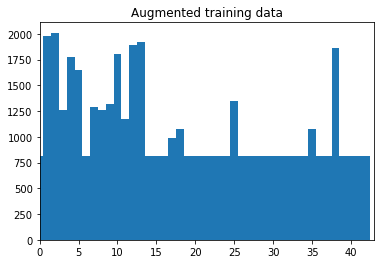

In [41]:
valid_hist, bin_edges = np.histogram(y_train, bins = range(n_classes + 1))
plt.bar(bin_edges[:-1], valid_hist, width=1)
plt.xlim(min(bin_edges), max(bin_edges))
plt.title('Augmented training data')
plt.show()

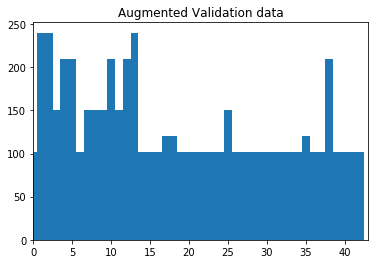

In [42]:
valid_hist, bin_edges = np.histogram(y_valid, bins = range(n_classes + 1))
plt.bar(bin_edges[:-1], valid_hist, width=1)
plt.xlim(min(bin_edges), max(bin_edges))
plt.title('Augmented Validation data')
plt.show()

In [43]:
#Helper function
from tensorflow.contrib.layers import flatten

def get_conv_filter_bias(input_, height, width, depth, mu=0, sigma=0.1):
    input_channels = input_.get_shape()[-1].value
    return (
        tf.Variable(tf.truncated_normal((height, width, input_channels, depth), mean=mu, stddev=sigma)),
        tf.zeros((depth))
    )

In [77]:
# Define model classifier using conv net


def lecun_article_model(x):  # 32 x 32 x 1 
    fw1, b1 = get_conv_filter_bias(x, 5, 5, 6)  # 28 X 28 X 6, 6
    conv_layer1 = tf.nn.bias_add(tf.nn.conv2d(x, fw1, [1, 1, 1, 1], 'VALID'), b1)
    activated1 = tf.nn.relu(conv_layer1)
    activated1 = tf.nn.dropout(activated1, conv_keep_prob)
    pooled1 = tf.nn.max_pool(activated1, [1, 2, 2, 1], [1, 2, 2, 1], 'VALID')  # 14 x 14 x 32
    
    fw2, b2 = get_conv_filter_bias(pooled1, 5, 5, 16)  # 10 x 10 x 16, 16
    conv_layer2 = tf.nn.bias_add(tf.nn.conv2d(pooled1, fw2, [1, 1, 1, 1], 'VALID'), b2)
    activated2 = tf.nn.relu(conv_layer2)
    activated2 = tf.nn.dropout(activated2, conv_keep_prob)
    pooled2 = tf.nn.max_pool(activated2, [1, 2, 2, 1], [1, 2, 2, 1], 'VALID')  # 5 x 5 x 16
    
    fw3, b3 = get_conv_filter_bias(pooled2, 5, 5, 400)  # 1 x 1 x 400, 400
    conv_layer3 = tf.nn.bias_add(tf.nn.conv2d(pooled2, fw3, [1, 1, 1, 1], 'VALID'), b3)
    activated3 = tf.nn.relu(conv_layer3)
    activated3 = tf.nn.dropout(activated3, conv_keep_prob)
    #pooled3 = tf.nn.max_pool(activated3, [1, 2, 2, 1], [1, 2, 2, 1], 'VALID')  # 1 x 1 x 512
    
    '''fw4, b4 = get_conv_filter_bias(pooled3, 2, 2, 400)  # 1 x 1 x 400, 400
    conv_layer4 = tf.nn.bias_add(tf.nn.conv2d(pooled3, fw4, [1, 1, 1, 1], 'VALID'), b4)
    activated4 = tf.nn.relu(conv_layer4)
    activated4 = tf.nn.dropout(activated4, conv_keep_prob)'''
    
    flattened = tf.concat_v2([flatten(activated3), flatten(pooled2)], 1)
    flattened = tf.nn.dropout(flattened, fc_keep_prob)
    
    fc_w3, fc_b3 = tf.Variable(tf.random_normal((800, n_classes))), tf.zeros((n_classes))
    fc_out3 = tf.add(tf.matmul(flattened, fc_w3), fc_b3)
    return tf.nn.relu(fc_out3)

In [44]:
def tweaked_lenet(x):  # 32 x 32 x 1 
    fw1, b1 = get_conv_filter_bias(x, 5, 5, 16)  # 28 X 28 X 6, 6
    conv_layer1 = tf.nn.bias_add(tf.nn.conv2d(x, fw1, [1, 1, 1, 1], 'VALID'), b1)
    activated1 = tf.nn.relu(conv_layer1)
    activated1 = tf.nn.dropout(activated1, conv_keep_prob)
    pooled1 = tf.nn.max_pool(activated1, [1, 2, 2, 1], [1, 2, 2, 1], 'VALID')  # 14 x 14 x 6
    print(pooled1.get_shape())
    
    fw2, b2 = get_conv_filter_bias(pooled1, 5, 5, 32)  # 10 x 10 x 16, 16
    conv_layer2 = tf.nn.bias_add(tf.nn.conv2d(pooled1, fw2, [1, 1, 1, 1], 'VALID'), b2)
    activated2 = tf.nn.relu(conv_layer2)
    activated2 = tf.nn.dropout(activated2, conv_keep_prob)
    pooled2 = tf.nn.max_pool(activated2, [1, 2, 2, 1], [1, 2, 2, 1], 'VALID')  # 5 x 5 x 16
    print(pooled2.get_shape())
    
    fw3, b3 = get_conv_filter_bias(pooled2, 5, 5, 430)  # 1 x 1 x 430, 430
    conv_layer3 = tf.nn.bias_add(tf.nn.conv2d(pooled2, fw3, [1, 1, 1, 1], 'VALID'), b3)
    activated3 = tf.nn.relu(conv_layer3)
    activated3 = tf.nn.dropout(activated3, conv_keep_prob)
    print(activated3.get_shape())

    flattened = flatten(activated3)
    flattened = tf.nn.dropout(flattened, fc_keep_prob)
    print(flattened.get_shape())
    fc_w3, fc_b3 = tf.Variable(tf.random_normal((430, n_classes))), tf.zeros((n_classes))
    fc_out3 = tf.add(tf.matmul(flattened, fc_w3), fc_b3)
    return tf.nn.relu(fc_out3)

In [82]:
def LeNet(x):    
    # Arguments used for tf.truncated_normal, randomly defines variables for the weights and biases for each layer
    mu = 0
    sigma = 0.1
    
    # SOLUTION: Layer 1: Convolutional. Input = 32x32x1. Output = 28x28x6.
    conv1_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 1, 6), mean = mu, stddev = sigma))
    conv1_b = tf.Variable(tf.zeros(6))
    conv1   = tf.nn.conv2d(x, conv1_W, strides=[1, 1, 1, 1], padding='VALID') + conv1_b

    # SOLUTION: Activation.
    conv1 = tf.nn.relu(conv1)

    # SOLUTION: Pooling. Input = 28x28x6. Output = 14x14x6.
    conv1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # SOLUTION: Layer 2: Convolutional. Output = 10x10x16.
    conv2_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 6, 16), mean = mu, stddev = sigma))
    conv2_b = tf.Variable(tf.zeros(16))
    conv2   = tf.nn.conv2d(conv1, conv2_W, strides=[1, 1, 1, 1], padding='VALID') + conv2_b
    
    # SOLUTION: Activation.
    conv2 = tf.nn.relu(conv2)

    # SOLUTION: Pooling. Input = 10x10x16. Output = 5x5x16.
    conv2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # SOLUTION: Flatten. Input = 5x5x16. Output = 400.
    fc0   = flatten(conv2)
    
    # SOLUTION: Layer 3: Fully Connected. Input = 400. Output = 120.
    fc1_W = tf.Variable(tf.truncated_normal(shape=(400, 120), mean = mu, stddev = sigma))
    fc1_b = tf.Variable(tf.zeros(120))
    fc1   = tf.matmul(fc0, fc1_W) + fc1_b
    
    # SOLUTION: Activation.
    fc1    = tf.nn.relu(fc1)
    fc1 = tf.nn.dropout(fc1, fc_keep_prob)

    # SOLUTION: Layer 4: Fully Connected. Input = 120. Output = 84.
    fc2_W  = tf.Variable(tf.truncated_normal(shape=(120, 84), mean = mu, stddev = sigma))
    fc2_b  = tf.Variable(tf.zeros(84))
    fc2    = tf.matmul(fc1, fc2_W) + fc2_b
    
    # SOLUTION: Activation.
    fc2    = tf.nn.relu(fc2)
    fc2 = tf.nn.dropout(fc2, fc_keep_prob)

    # SOLUTION: Layer 5: Fully Connected. Input = 84. Output = 10.
    fc3_W  = tf.Variable(tf.truncated_normal(shape=(84, 43), mean = mu, stddev = sigma))
    fc3_b  = tf.Variable(tf.zeros(43))
    logits = tf.matmul(fc2, fc3_W) + fc3_b
    
    return logits

In [42]:
def tweaked_lenet2(x):  # 32 x 32 x 1 
    fw1, b1 = get_conv_filter_bias(x, 5, 5, 32)  # 28 X 28 X 32, 32
    conv_layer1 = tf.nn.bias_add(tf.nn.conv2d(x, fw1, [1, 1, 1, 1], 'VALID'), b1)
    activated1 = tf.nn.relu(conv_layer1)
    #activated1 = tf.nn.dropout(activated1, conv_keep_prob)
    pooled1 = tf.nn.max_pool(activated1, [1, 2, 2, 1], [1, 2, 2, 1], 'VALID')  # 14 x 14 x 32
    #pooled1 = tf.nn.dropout(pooled1, conv_keep_prob)
    
    fw2, b2 = get_conv_filter_bias(pooled1, 3, 3, 64)  # 12 x 12 x 64, 64
    conv_layer2 = tf.nn.bias_add(tf.nn.conv2d(pooled1, fw2, [1, 1, 1, 1], 'VALID'), b2)
    activated2 = tf.nn.relu(conv_layer2)
    #activated2 = tf.nn.dropout(activated2, conv_keep_prob)
    pooled2 = tf.nn.max_pool(activated2, [1, 2, 2, 1], [1, 2, 2, 1], 'VALID')  # 6 x 6 x 64
    #pooled2 = tf.nn.dropout(pooled2, conv_keep_prob)
    
    fw3, b3 = get_conv_filter_bias(pooled2, 3, 3, 64)  # 4 x 4 x 64, 64
    conv_layer3 = tf.nn.bias_add(tf.nn.conv2d(pooled2, fw3, [1, 1, 1, 1], 'VALID'), b3)
    activated3 = tf.nn.relu(conv_layer3)
    activated3 = tf.nn.dropout(activated3, conv_keep_prob)
    
    flattened = flatten(activated3)
    flattened = tf.nn.dropout(flattened, fc_keep_prob)
    
    fc_w3, fc_b3 = tf.Variable(tf.random_normal((1024, n_classes))), tf.zeros((n_classes))
    fc_out3 = tf.add(tf.matmul(flattened, fc_w3), fc_b3)
    out = tf.nn.relu(fc_out3)
    return tf.nn.dropout(out, fc_keep_prob)
    #return out

In [45]:
# Hyperparameters
EPOCHS = 65
BATCH_SIZE = 128
learning_rate = 0.0007

In [59]:
# Placeholders for inputs to the architecture
tf.reset_default_graph()
x = tf.placeholder(tf.float32, (None, 32, 32, 1))
y = tf.placeholder(tf.int32, (None))
one_hot_y = tf.one_hot(y, n_classes)
conv_keep_prob = tf.placeholder(tf.float32)
fc_keep_prob = tf.placeholder(tf.float32)

In [60]:
# Define pipeline
logits = tweaked_lenet(x)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=one_hot_y, logits=logits)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
training_operation = optimizer.minimize(loss_operation)

(?, 14, 14, 16)
(?, 5, 5, 32)
(?, 1, 1, 430)
(?, 430)


In [61]:
# Model Evaluation

correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))  # Validate in the horizontal direction
accuracy_prediction = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))


def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_prediction, feed_dict={x: batch_x, y: batch_y, conv_keep_prob: 1.0, fc_keep_prob: 1.0})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

### Train and Validate the Model

In [63]:
# Saver

saver = tf.train.Saver()

A validation set can be used to assess how well the model is performing. A low accuracy on the training and validation
sets imply underfitting. A high accuracy on the training set but low accuracy on the validation set implies overfitting.

In [64]:
# Training
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train)
    
    print("Training...-----")
    print()
    for i in range(EPOCHS):
        X_train, y_train = shuffle(X_train, y_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y, conv_keep_prob: 0.7, fc_keep_prob: 0.5})
        
        training_accuracy = evaluate(X_train, y_train)
        validation_accuracy = evaluate(X_valid, y_valid)
        print("EPOCH {} ...".format(i+1))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        print("Training Accuracy = {:.3f}".format(training_accuracy))
        print()
        
    saver.save(sess, './lenet')
    print("Model saved")

Training...-----

EPOCH 1 ...
Validation Accuracy = 0.036
Training Accuracy = 0.031

EPOCH 2 ...
Validation Accuracy = 0.298
Training Accuracy = 0.346

EPOCH 3 ...
Validation Accuracy = 0.617
Training Accuracy = 0.702

EPOCH 4 ...
Validation Accuracy = 0.699
Training Accuracy = 0.801

EPOCH 5 ...
Validation Accuracy = 0.755
Training Accuracy = 0.859

EPOCH 6 ...
Validation Accuracy = 0.787
Training Accuracy = 0.890

EPOCH 7 ...
Validation Accuracy = 0.817
Training Accuracy = 0.910

EPOCH 8 ...
Validation Accuracy = 0.839
Training Accuracy = 0.933

EPOCH 9 ...
Validation Accuracy = 0.863
Training Accuracy = 0.949

EPOCH 10 ...
Validation Accuracy = 0.873
Training Accuracy = 0.959

EPOCH 11 ...
Validation Accuracy = 0.875
Training Accuracy = 0.965

EPOCH 12 ...
Validation Accuracy = 0.886
Training Accuracy = 0.971

EPOCH 13 ...
Validation Accuracy = 0.880
Training Accuracy = 0.973

EPOCH 14 ...
Validation Accuracy = 0.889
Training Accuracy = 0.979

EPOCH 15 ...
Validation Accuracy = 0.89

### Test the model (Moment of truth)

In [66]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver2 = tf.train.import_meta_graph('./lenet.meta')
    saver2.restore(sess, "./lenet")
    test_accuracy = evaluate(X_test, y_test)
    print("Test Set Accuracy = {:.3f}".format(test_accuracy))

Test Set Accuracy = 0.953


# ---

## Step 3: Test a Model on New Images

To give yourself more insight into how your model is working, download at least five pictures of German traffic signs from the web and use your model to predict the traffic sign type.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Load and Output the Images

####  Loading images
The images have been downloaded from the Test section of official dataset website http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset#Downloads.

Amonsgt those, the first 6 images have been selected, which have the names like 00000.ppm to 00005.ppm
Each image is of shape 52 x 54. Need to reshape it to 32 x 32

In [109]:
#Loading ...
X_new_images = [cv2.imread('0000%s.ppm' % (i)) for i in range(6)]  # Each image is of shape 52 x 54
X_new_images = [cv2.resize(img, (32, 32)) for img in new_images]

#### Plotting 

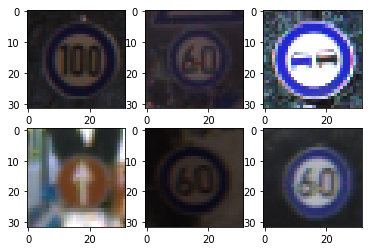

In [110]:
for idx, img in enumerate(X_new_images):
    plt.subplot(231 + idx)
    plt.imshow(img)


#### Manually decising the labels 

In [117]:
y_new_images = np.array([7, 3, 9, 35, 3, 3])

### Predict the Sign Type for Each Image

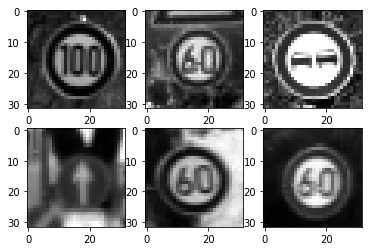

In [111]:
X_grayscale_new_images = grayscale(new_images)
for idx, img in enumerate(X_grayscale_new_images):
    plt.subplot(231 + idx)
    plt.imshow(img, cmap='gray')

In [112]:
X_new_images = normalize(grayscale_new_images)
print(X_new_images.shape)

(6, 32, 32, 1)


### Analyze Performance

In [4]:
### Calculate the accuracy for these 5 new images. 
### For example, if the model predicted 1 out of 5 signs correctly, it's 20% accurate on these new images.

In [121]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver3 = tf.train.import_meta_graph('./lenet.meta')
    saver3.restore(sess, "./lenet")
    accuracy_new_images = evaluate(X_new_images, y_new_images)
    print("New Images Accuracy = {:.3f}".format(accuracy_new_images))

New Images Accuracy = 1.000


In [123]:
with tf.Session() as sess:
    sess.run(print(logits))

Tensor("Relu_3:0", shape=(?, 43), dtype=float32)


TypeError: Fetch argument None has invalid type <class 'NoneType'>

### Output Top 5 Softmax Probabilities For Each Image Found on the Web

For each of the new images, print out the model's softmax probabilities to show the **certainty** of the model's predictions (limit the output to the top 5 probabilities for each image). [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. 

The example below demonstrates how tf.nn.top_k can be used to find the top k predictions for each image.

`tf.nn.top_k` will return the values and indices (class ids) of the top k predictions. So if k=3, for each sign, it'll return the 3 largest probabilities (out of a possible 43) and the correspoding class ids.

Take this numpy array as an example. The values in the array represent predictions. The array contains softmax probabilities for five candidate images with six possible classes. `tf.nn.top_k` is used to choose the three classes with the highest probability:

```
# (5, 6) array
a = np.array([[ 0.24879643,  0.07032244,  0.12641572,  0.34763842,  0.07893497,
         0.12789202],
       [ 0.28086119,  0.27569815,  0.08594638,  0.0178669 ,  0.18063401,
         0.15899337],
       [ 0.26076848,  0.23664738,  0.08020603,  0.07001922,  0.1134371 ,
         0.23892179],
       [ 0.11943333,  0.29198961,  0.02605103,  0.26234032,  0.1351348 ,
         0.16505091],
       [ 0.09561176,  0.34396535,  0.0643941 ,  0.16240774,  0.24206137,
         0.09155967]])
```

Running it through `sess.run(tf.nn.top_k(tf.constant(a), k=3))` produces:

```
TopKV2(values=array([[ 0.34763842,  0.24879643,  0.12789202],
       [ 0.28086119,  0.27569815,  0.18063401],
       [ 0.26076848,  0.23892179,  0.23664738],
       [ 0.29198961,  0.26234032,  0.16505091],
       [ 0.34396535,  0.24206137,  0.16240774]]), indices=array([[3, 0, 5],
       [0, 1, 4],
       [0, 5, 1],
       [1, 3, 5],
       [1, 4, 3]], dtype=int32))
```

Looking just at the first row we get `[ 0.34763842,  0.24879643,  0.12789202]`, you can confirm these are the 3 largest probabilities in `a`. You'll also notice `[3, 0, 5]` are the corresponding indices.

In [3]:
### Print out the top five softmax probabilities for the predictions on the German traffic sign images found on the web. 
### Feel free to use as many code cells as needed.

### Project Writeup

Once you have completed the code implementation, document your results in a project writeup using this [template](https://github.com/udacity/CarND-Traffic-Sign-Classifier-Project/blob/master/writeup_template.md) as a guide. The writeup can be in a markdown or pdf file. 

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

---

## Step 4 (Optional): Visualize the Neural Network's State with Test Images

 This Section is not required to complete but acts as an additional excersise for understaning the output of a neural network's weights. While neural networks can be a great learning device they are often referred to as a black box. We can understand what the weights of a neural network look like better by plotting their feature maps. After successfully training your neural network you can see what it's feature maps look like by plotting the output of the network's weight layers in response to a test stimuli image. From these plotted feature maps, it's possible to see what characteristics of an image the network finds interesting. For a sign, maybe the inner network feature maps react with high activation to the sign's boundary outline or to the contrast in the sign's painted symbol.

 Provided for you below is the function code that allows you to get the visualization output of any tensorflow weight layer you want. The inputs to the function should be a stimuli image, one used during training or a new one you provided, and then the tensorflow variable name that represents the layer's state during the training process, for instance if you wanted to see what the [LeNet lab's](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) feature maps looked like for it's second convolutional layer you could enter conv2 as the tf_activation variable.

For an example of what feature map outputs look like, check out NVIDIA's results in their paper [End-to-End Deep Learning for Self-Driving Cars](https://devblogs.nvidia.com/parallelforall/deep-learning-self-driving-cars/) in the section Visualization of internal CNN State. NVIDIA was able to show that their network's inner weights had high activations to road boundary lines by comparing feature maps from an image with a clear path to one without. Try experimenting with a similar test to show that your trained network's weights are looking for interesting features, whether it's looking at differences in feature maps from images with or without a sign, or even what feature maps look like in a trained network vs a completely untrained one on the same sign image.

<figure>
 <img src="visualize_cnn.png" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above)</p> 
 </figcaption>
</figure>
 <p></p> 


In [ ]:
### Visualize your network's feature maps here.
### Feel free to use as many code cells as needed.

# image_input: the test image being fed into the network to produce the feature maps
# tf_activation: should be a tf variable name used during your training procedure that represents the calculated state of a specific weight layer
# activation_min/max: can be used to view the activation contrast in more detail, by default matplot sets min and max to the actual min and max values of the output
# plt_num: used to plot out multiple different weight feature map sets on the same block, just extend the plt number for each new feature map entry

def outputFeatureMap(image_input, tf_activation, activation_min=-1, activation_max=-1 ,plt_num=1):
    # Here make sure to preprocess your image_input in a way your network expects
    # with size, normalization, ect if needed
    # image_input =
    # Note: x should be the same name as your network's tensorflow data placeholder variable
    # If you get an error tf_activation is not defined it may be having trouble accessing the variable from inside a function
    activation = tf_activation.eval(session=sess,feed_dict={x : image_input})
    featuremaps = activation.shape[3]
    plt.figure(plt_num, figsize=(15,15))
    for featuremap in range(featuremaps):
        plt.subplot(6,8, featuremap+1) # sets the number of feature maps to show on each row and column
        plt.title('FeatureMap ' + str(featuremap)) # displays the feature map number
        if activation_min != -1 & activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin =activation_min, vmax=activation_max, cmap="gray")
        elif activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmax=activation_max, cmap="gray")
        elif activation_min !=-1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin=activation_min, cmap="gray")
        else:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", cmap="gray")